In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow import keras
import os
from sklearn import model_selection
from sklearn import utils
from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy import ndimage
from gc import collect
import matplotlib.pyplot as plt
from collections import Counter
from seaborn import heatmap


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [3]:
labels = get_labels('/kaggle/input/labelsssss/labels.csv')
numbers_per_class = [0, 0, 0, 0]
for i in labels:
    numbers_per_class[np.argmax(labels[i])] += 1

proportion_per_class = [round(number_of_class/sum(numbers_per_class), 2) for number_of_class in numbers_per_class]
proportion_per_class

[0.35, 0.25, 0.23, 0.17]

In [4]:
path = '/kaggle/input/192x256xdepth/'
dirs = os.listdir(path)

X = [path + i for i in os.listdir(path)]
y = [np.argmax(labels[(path+i)[-14:-4]]) for i in os.listdir(path)]

In [5]:
def balancing_batch(X, y, max_value):
    numbers_per_class = sorted(Counter(y).items())
    
    if len(numbers_per_class) == 1:
        return X[0:1], y[0:1] #return only the first image because the batch has only one class
    
    if numbers_per_class[0][1] > numbers_per_class[1][1]:
        max_per_class = numbers_per_class[1][1]
    else:
        max_per_class = numbers_per_class[0][1]
    
    if max_per_class > max_value//2:
        max_per_class = max_value//2
        
    X, y = utils.shuffle(X, y)
    new_X, new_y = [], []
    counter_class_zero = 0
    counter_class_one = 0
    for test_x, test_y in zip(X, y):
        if test_y == 0 and counter_class_zero < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_zero += 1
        elif test_y == 1 and counter_class_one < max_per_class//2:
            new_X.append(test_x)
            new_y.append(test_y)
            counter_class_one += 1
    
    return np.array(new_X, dtype='float16'), np.array(new_y, dtype='float16')

In [6]:
def separate_slices(img):
    'function to separate 2d images of 3d original image'
    slices = []

    for i in range(img.shape[-2]):
        slices.append(np.array(img[:, :, i]))

    slices.append(np.mean(img, axis=-2)) #including mean of slices
        
    return slices

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y,random_state=42, train_size=0.8)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, objective, list_IDs, labels_dir, batch_size, sub_batch_size, dim_img, training, shuffle=True):
        self.objective = objective # list representing one hot encoding for choice label ([1, 0, 0, 0] for normal, [0, 0, 0, 1] for cancer ..)
        self.list_IDs = list_IDs # array of strings with original images name with directory
        self.labels = self.__get_labels(labels_dir) #dict with labels of all images
        self.batch_size = batch_size #3d-images per batch
        self.sub_batch_size = sub_batch_size #quantity of sub-images per batch will be choose to train
        self.dim_img = dim_img # tuple with width and height of image like (192, 256)
        self.training = training # true if generator is for training, false if generator is for validation
        self.shuffle = shuffle # true or false to shuffle data after any epochs
        self.on_epoch_end() # call of the function
        
    
    def __get_labels(self, label_file):
        'take the dict with labels of images'
        labels = pd.read_csv(label_file)
        cancer_labels = dict()

        for p in labels.index:
            cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

        return cancer_labels
    
    def __data_augmentation(self, x):
        'generate variations of images'
        new_images = []
        x = x.astype('float16')
        new_images.append(x)
        
        """
        for i in range(3):
            img = x + np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(img)
            
            img = x - np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(img)
        """
        
        x = cv2.flip(x.astype('float32'), 1).astype('float16')
        
        """
        for i in range(3):
            img = x + np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(np.expand_dims(img, -1))
            
            img = x - np.random.random()/4
            img[:,:][img[:,:]>1]  = 1
            img[:,:][img[:,:]<0]  = 0
            new_images.append(np.expand_dims(img, -1))
        """
            
        new_images.append(np.expand_dims(x, -1))

        return utils.shuffle(new_images)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    

    def __getitem__(self, index):        
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        if self.training:
            X, y = balancing_batch(X, y, self.sub_batch_size)
            return np.array(X[0:self.sub_batch_size], dtype='float16'), np.array(y[0:self.sub_batch_size], dtype='uint8')
        
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        X = []
        y = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            prev_len_X = len(X)
            full_image = np.load(ID)
            new_images = separate_slices(full_image)
            if self.training:
                for img in new_images:
                    X += self.__data_augmentation(img)
            else:
                X = np.array(new_images, dtype='float16')
            
            #adding new data labels for y array
            for _ in range(len(X) - prev_len_X):
                if self.labels[ID[-14:-4]] == self.objective: #'-14:-4 represent a part of string with name of original image that slices was taken'
                    y.append(1)
                else:
                    y.append(0)
                    
        X, y = utils.shuffle(X, y)
        return X, y

In [9]:
class SE_ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

        self.SE = [keras.layers.GlobalAvgPool2D(),
                   keras.layers.Flatten(),
                   keras.layers.Dense(filters//4, activation='relu'),
                   keras.layers.Dense(filters, activation='sigmoid'),
                   keras.layers.Reshape([1,1,filters])]

        self.block_layers = [keras.layers.Conv2D(filters//4, kernel_size=(1,1), strides=1, padding='same', use_bias=False),
                             keras.layers.BatchNormalization(),
                             self.activation,
                             keras.layers.Conv2D(filters//4, kernel_size=(3,4), strides=strides, padding='same', use_bias=False),
                             keras.layers.BatchNormalization(),
                             self.activation,
                             keras.layers.Conv2D(filters, kernel_size=(1,1), strides=1, padding='same', use_bias=False),
                             keras.layers.BatchNormalization()]
        
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [keras.layers.Conv2D(filters, kernel_size=(1,1), strides=strides, padding='same', use_bias=False),
                                keras.layers.BatchNormalization()]

    def call(self, x):
        inputs = tf.identity(x)
        x1 = tf.identity(x)
        
        for layer in self.block_layers:
            x1 = layer(x1)

        x2 = tf.identity(x1)
        for layer in self.SE:
            x2 = layer(x2)
        
        prod_calibration = x1*x2
        
        for layer in self.skip_layers:
            inputs = layer(inputs)
        
        
        return tf.concat([prod_calibration, inputs], axis=-1)

def get_resnet18():
    resnet18 = keras.models.Sequential()
    resnet18.add(keras.layers.Conv2D(filters=64, kernel_size=(7,9), strides=2, padding='same', use_bias=False, input_shape=(192, 256, 1)))
    resnet18.add(keras.layers.BatchNormalization())
    resnet18.add(keras.layers.Activation(keras.activations.relu))
    resnet18.add(keras.layers.MaxPool2D(pool_size=(3,4), strides=2, padding='same'))

    prev_filters = 64
    for filters in [64]*2 + [128]*2 + [256]*2 + [512]*2:
        if filters == prev_filters :
            strides = 1
        else:
            strides = 2
        resnet18.add(SE_ResidualUnit(filters, strides))
        prev_filters = filters

    resnet18.add(keras.layers.GlobalAvgPool2D())
    resnet18.add(keras.layers.Flatten())
    resnet18.add(keras.layers.Dense(units=1, activation='sigmoid'))

    return resnet18

**NORMAL**

In [11]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/normal_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [12]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[1, 0, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_resnet18()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 93s 2s/step - loss: 0.7014 - AUC_1: 0.5653 - accuracy: 0.5197 - precision: 0.5272 - recall: 0.3789 - val_loss: 0.7201 - val_AUC_1: 0.5000 - val_accuracy: 0.2919 - val_precision: 0.2919 - val_recall: 1.0000 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 63s 2s/step - loss: 0.6916 - AUC_1: 0.5840 - accuracy: 0.5482 - precision: 0.6145 - recall: 0.2568 - val_loss: 0.7481 - val_AUC_1: 0.4732 - val_accuracy: 0.2919 - val_precision: 0.2919 - val_recall: 1.0000 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 67s 2s/step - loss: 0.6659 - AUC_1: 0.6946 - accuracy: 0.5871 - precision: 0.7673 - recall: 0.2494 - val_loss: 0.7993 - val_AUC_1: 0.5000 - val_accuracy: 0.2919 - val_precision: 0.2919 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 65s 2s/step - loss: 0.6510 - AUC_1: 0.7230 - accuracy: 0.6391 - precision: 0.7839 - recall: 0.3833 - val_loss: 0

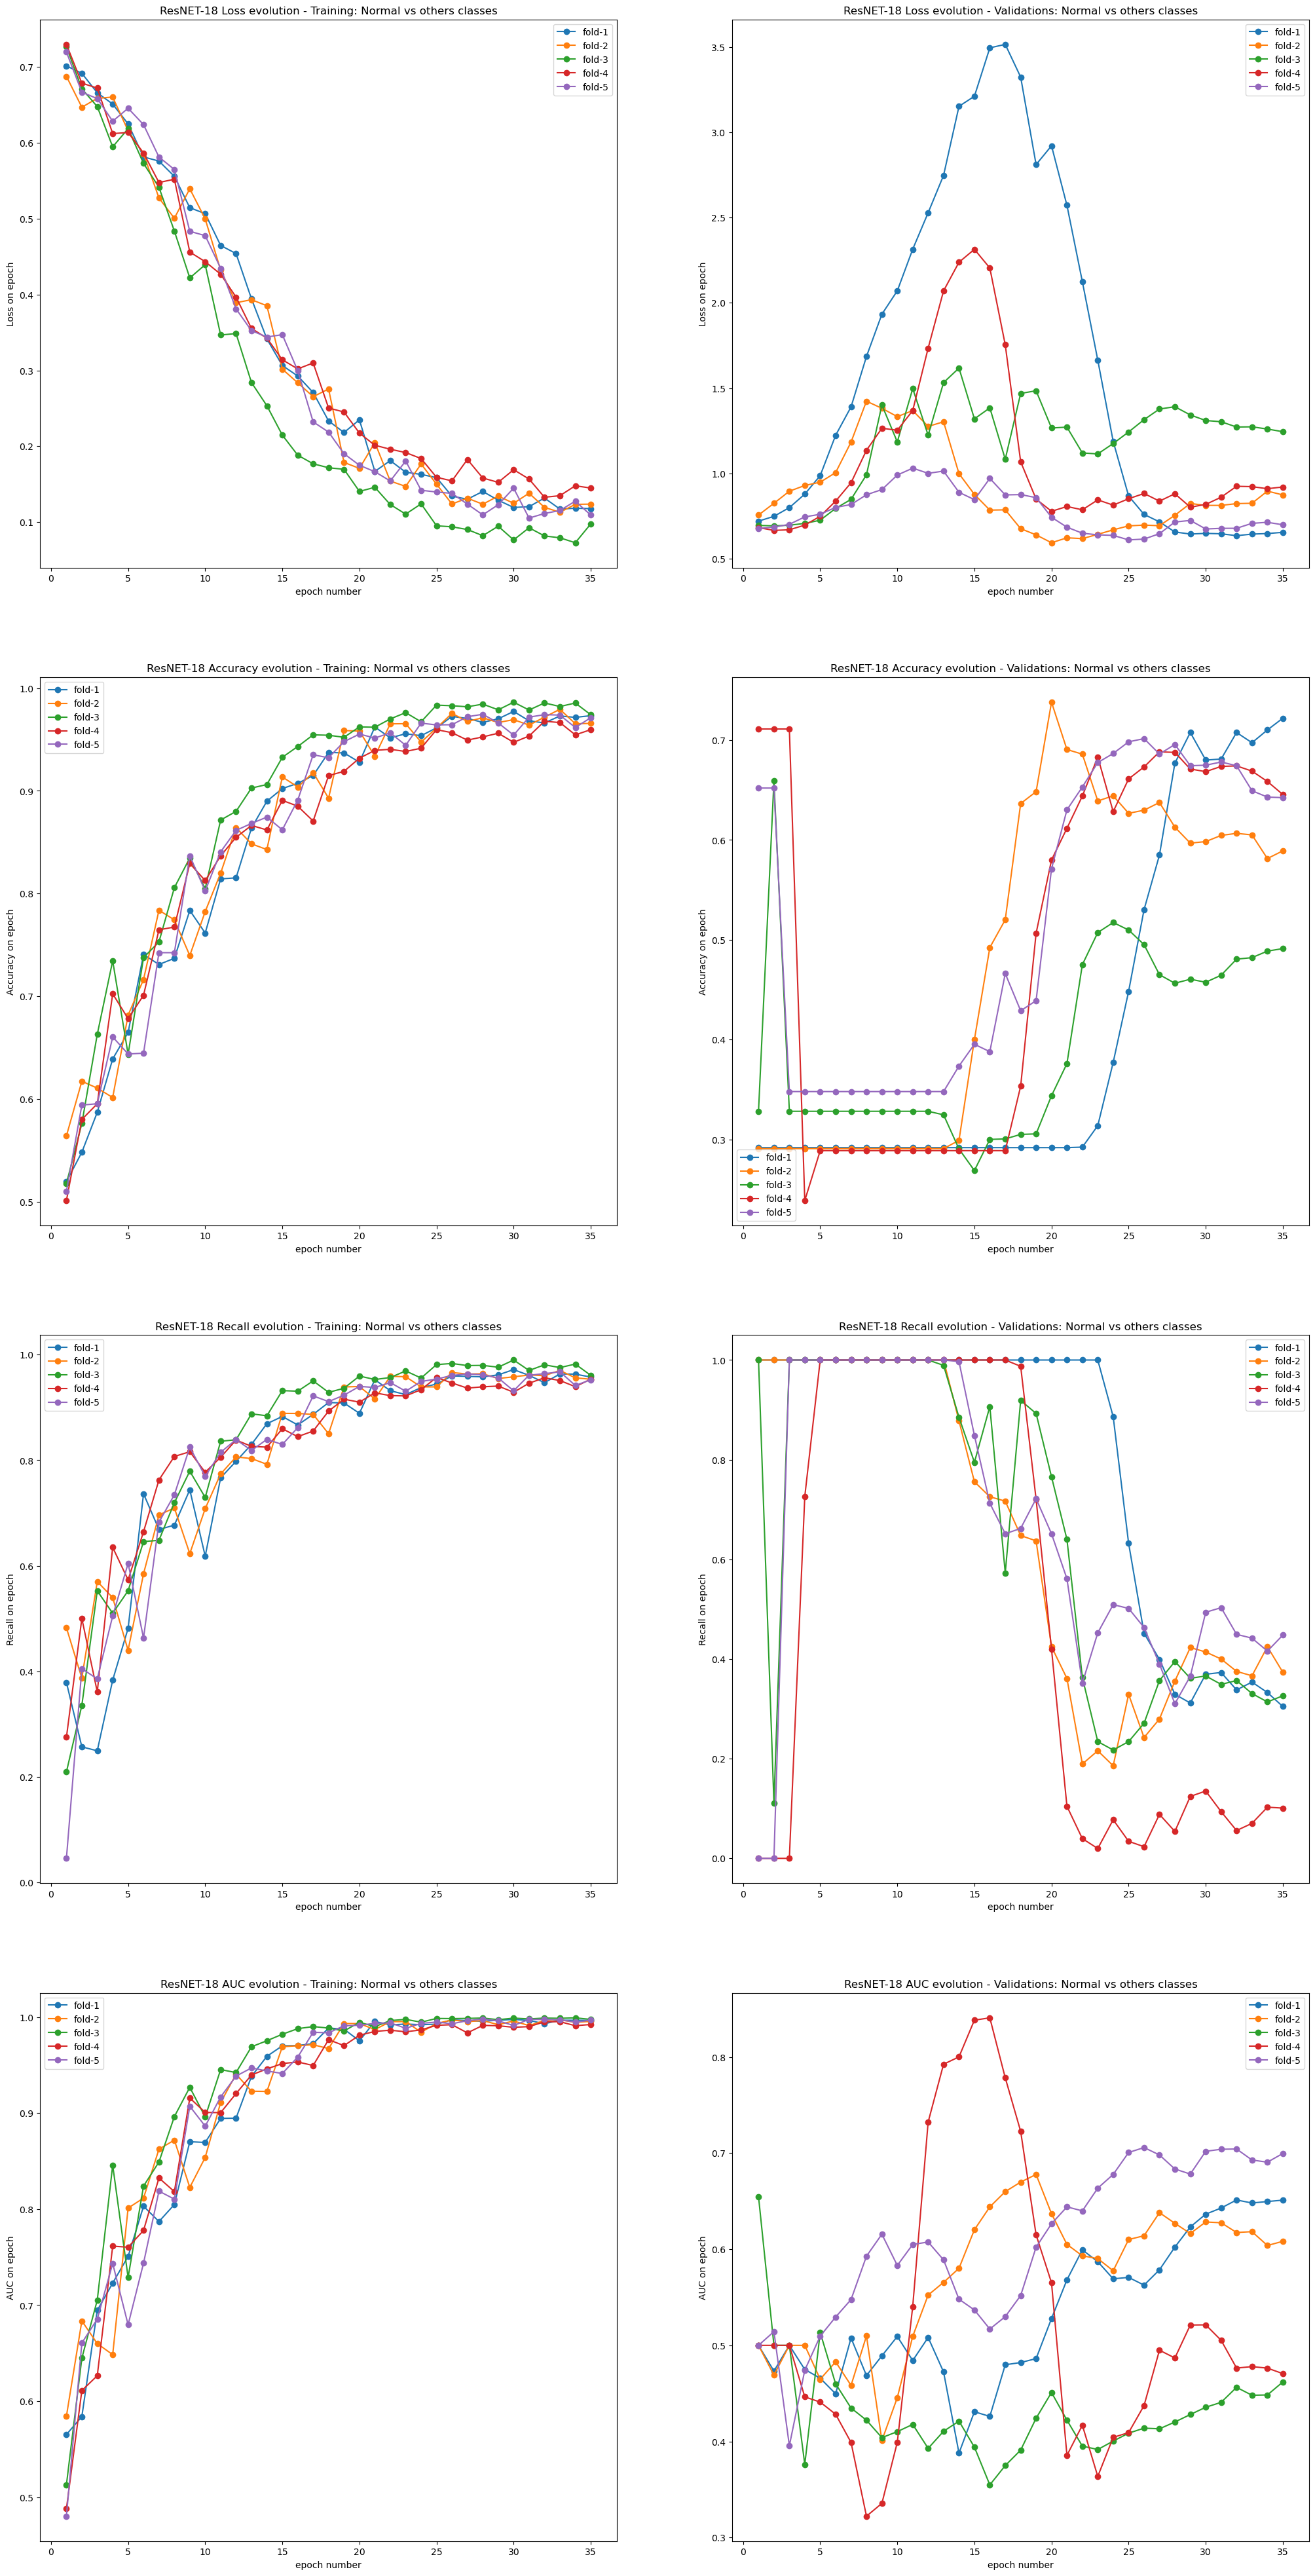

In [13]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Validations: Normal vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-18 AUC evolution - Training: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-18 AUC evolution - Validations: Normal vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [14]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9975018501281738
Best Accuracy in train: 0.9772829413414001
Best Precision in train: 0.9883669018745422
Best Recall in train: 0.9716343879699707

VALIDATION RESULTS:
Best AUC in validation: 0.6512376666069031
Best Accuracy in validation: 0.7218813896179199
Best Precision in validation: 0.5420560836791992
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9971696138381958
Best Accuracy in train: 0.9793647527694702
Best Precision in train: 0.9884536266326904
Best Recall in train: 0.9700525999069214

VALIDATION RESULTS:
Best AUC in validation: 0.6777918934822083
Best Accuracy in validation: 0.7378990650177002
Best Precision in validation: 0.5660377144813538
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9992348551750183
Best Accuracy in train: 0.9862771034240723
Best Precision in train: 0.9902697801589966
Best Recall in train: 0.98

**ACTIONABLE**

In [15]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/actionable_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [16]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 1, 0, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_resnet18()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 69s 1s/step - loss: 0.7484 - AUC_1: 0.4735 - accuracy: 0.4828 - precision: 0.4850 - recall: 0.5754 - val_loss: 0.7271 - val_AUC_1: 0.5000 - val_accuracy: 0.1953 - val_precision: 0.1953 - val_recall: 1.0000 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 64s 2s/step - loss: 0.6910 - AUC_1: 0.6195 - accuracy: 0.5547 - precision: 0.6809 - recall: 0.2042 - val_loss: 0.7420 - val_AUC_1: 0.4012 - val_accuracy: 0.1953 - val_precision: 0.1953 - val_recall: 1.0000 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 60s 2s/step - loss: 0.6494 - AUC_1: 0.7005 - accuracy: 0.5913 - precision: 0.6926 - recall: 0.3252 - val_loss: 0.6955 - val_AUC_1: 0.4879 - val_accuracy: 0.1953 - val_precision: 0.1953 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 59s 2s/step - loss: 0.6635 - AUC_1: 0.6618 - accuracy: 0.5530 - precision: 0.6394 - recall: 0.2387 - val_loss: 0

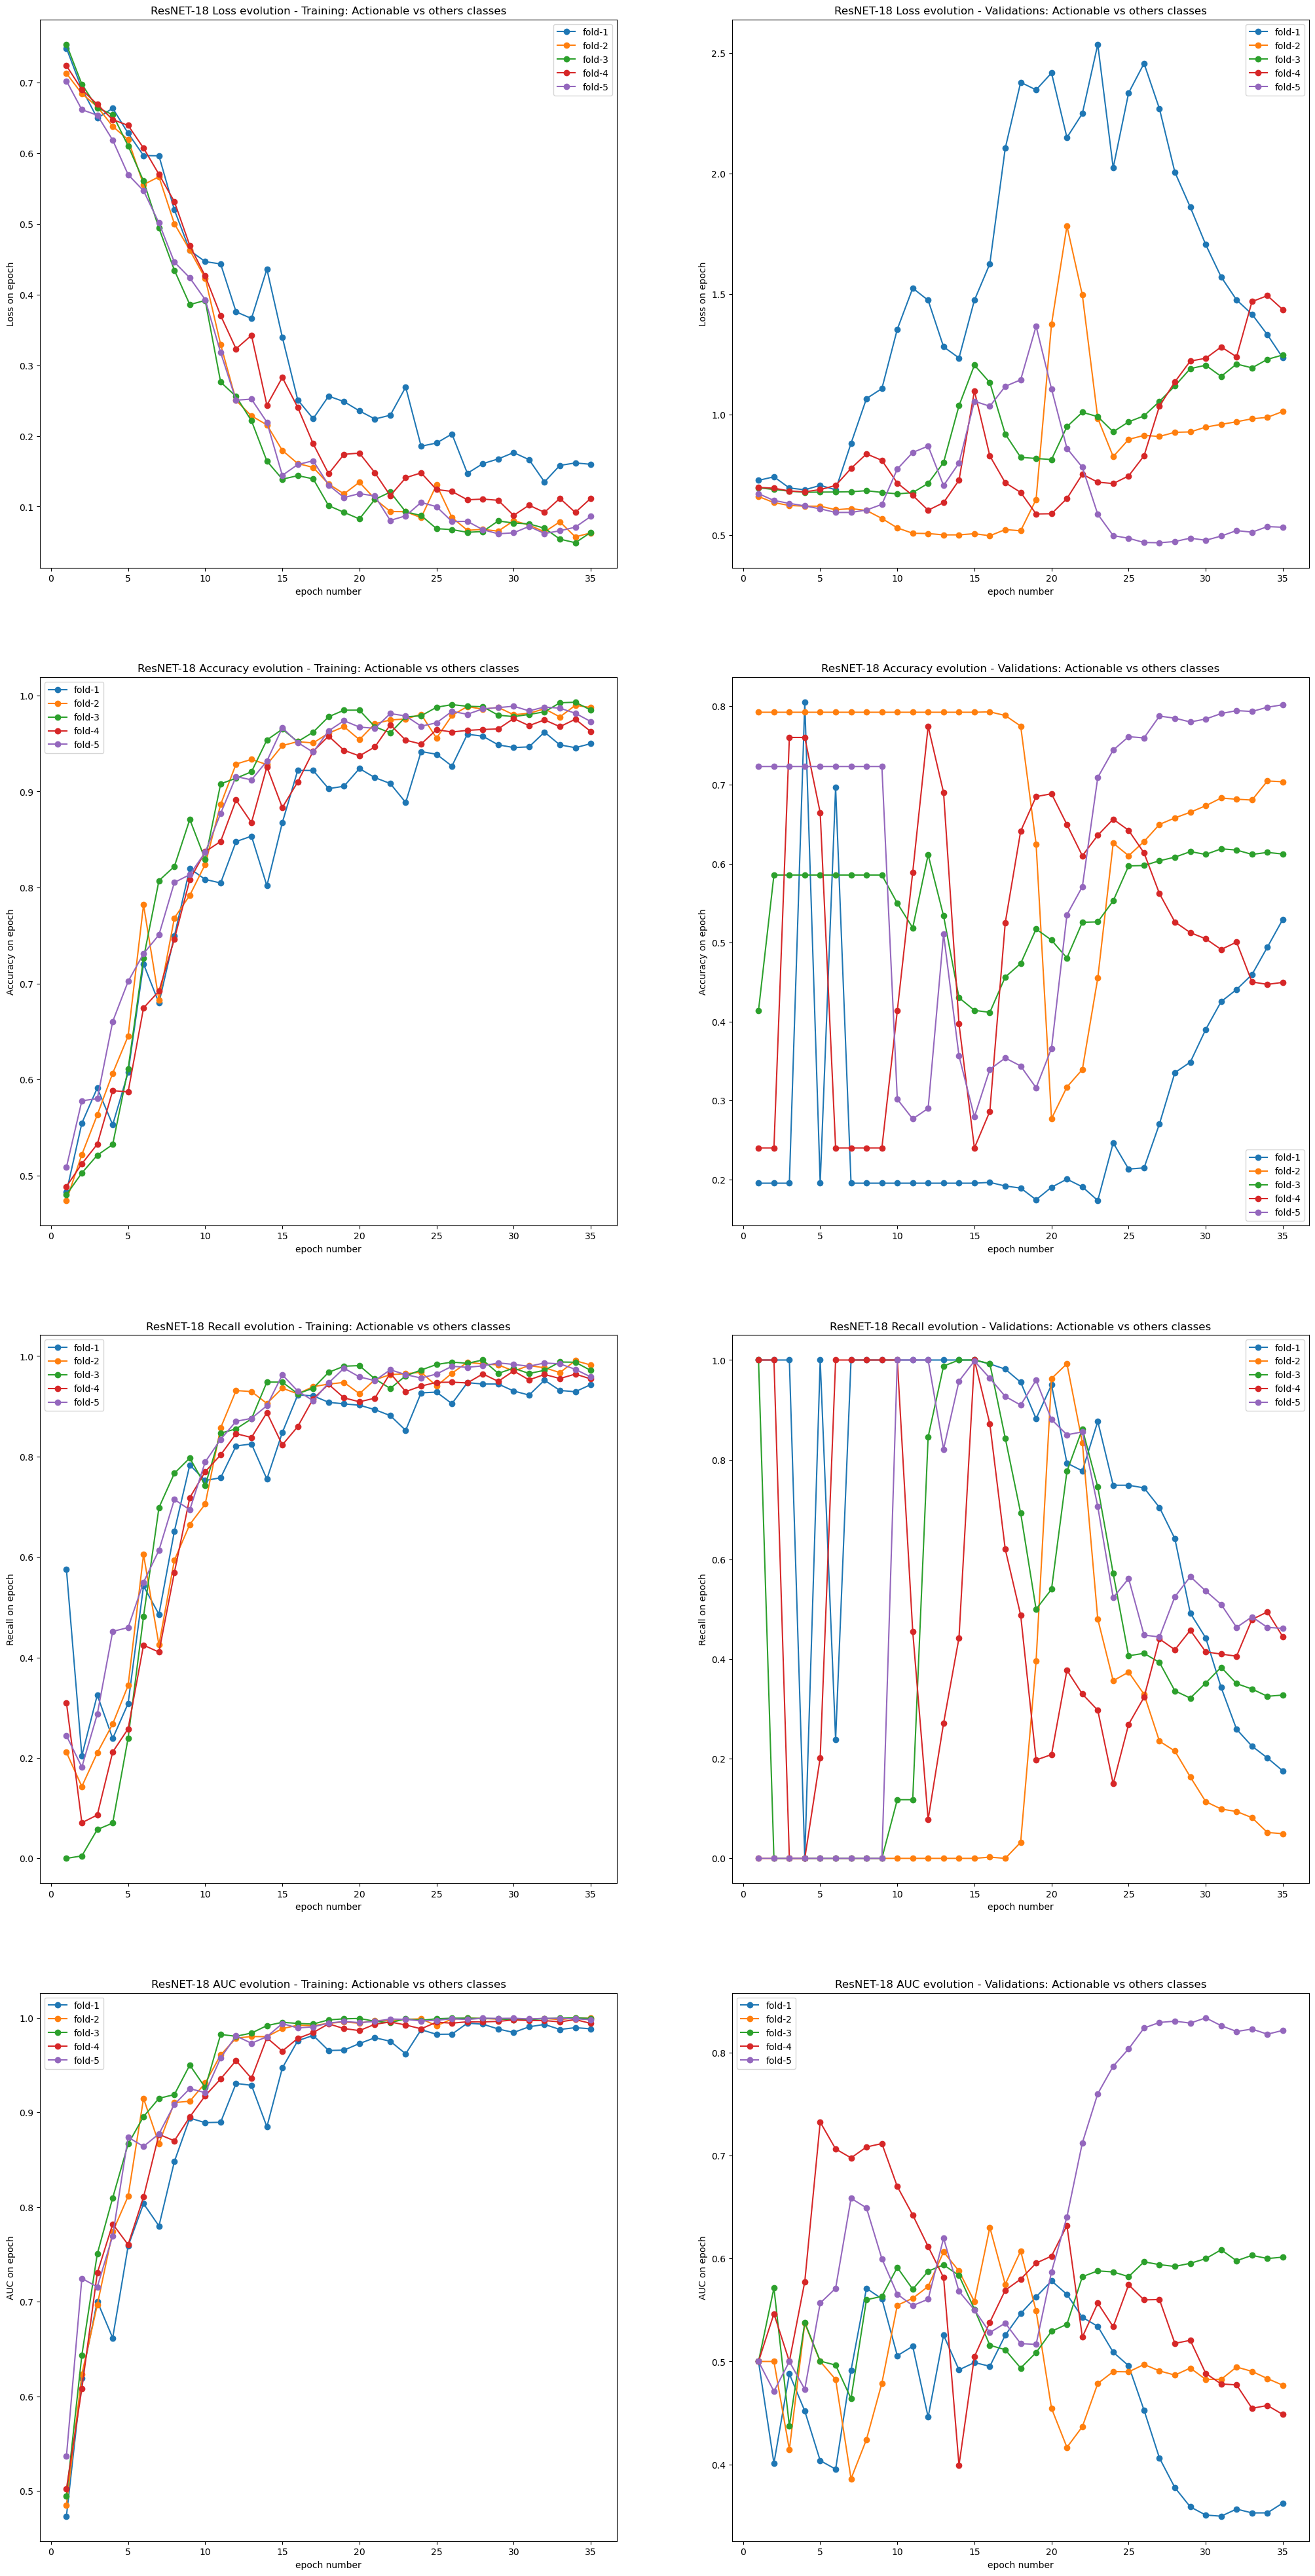

In [17]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Validations: Actionable vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-18 AUC evolution - Training: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-18 AUC evolution - Validations: Actionable vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [18]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")


Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9942467212677002
Best Accuracy in train: 0.9618521332740784
Best Precision in train: 0.9713243246078491
Best Recall in train: 0.9520295262336731

VALIDATION RESULTS:
Best AUC in validation: 0.5782870054244995
Best Accuracy in validation: 0.8047034740447998
Best Precision in validation: 0.23155216872692108
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9995937943458557
Best Accuracy in train: 0.9897494316101074
Best Precision in train: 0.9953727722167969
Best Recall in train: 0.990867555141449

VALIDATION RESULTS:
Best AUC in validation: 0.6303737759590149
Best Accuracy in validation: 0.7924819588661194
Best Precision in validation: 1.0
Best Recall in validation: 0.9925742745399475


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9998757839202881
Best Accuracy in train: 0.993015468120575
Best Precision in train: 0.9981538653373718
Best Recall in train: 0.992

**BENIGN**

In [19]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/benign_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [20]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 1, 0],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_resnet18()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 70s 1s/step - loss: 0.7209 - AUC_1: 0.4806 - accuracy: 0.5092 - precision: 0.5198 - recall: 0.2120 - val_loss: 0.6857 - val_AUC_1: 0.5000 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 59s 2s/step - loss: 0.7248 - AUC_1: 0.5657 - accuracy: 0.5005 - precision: 0.4118 - recall: 0.0042 - val_loss: 0.6779 - val_AUC_1: 0.5000 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 61s 2s/step - loss: 0.6903 - AUC_1: 0.7526 - accuracy: 0.5064 - precision: 0.9500 - recall: 0.0112 - val_loss: 0.6764 - val_AUC_1: 0.5043 - val_accuracy: 0.6053 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 58s 2s/step - loss: 0.6839 - AUC_1: 0.6994 - accuracy: 0.5639 - precision: 0.9177 - reca

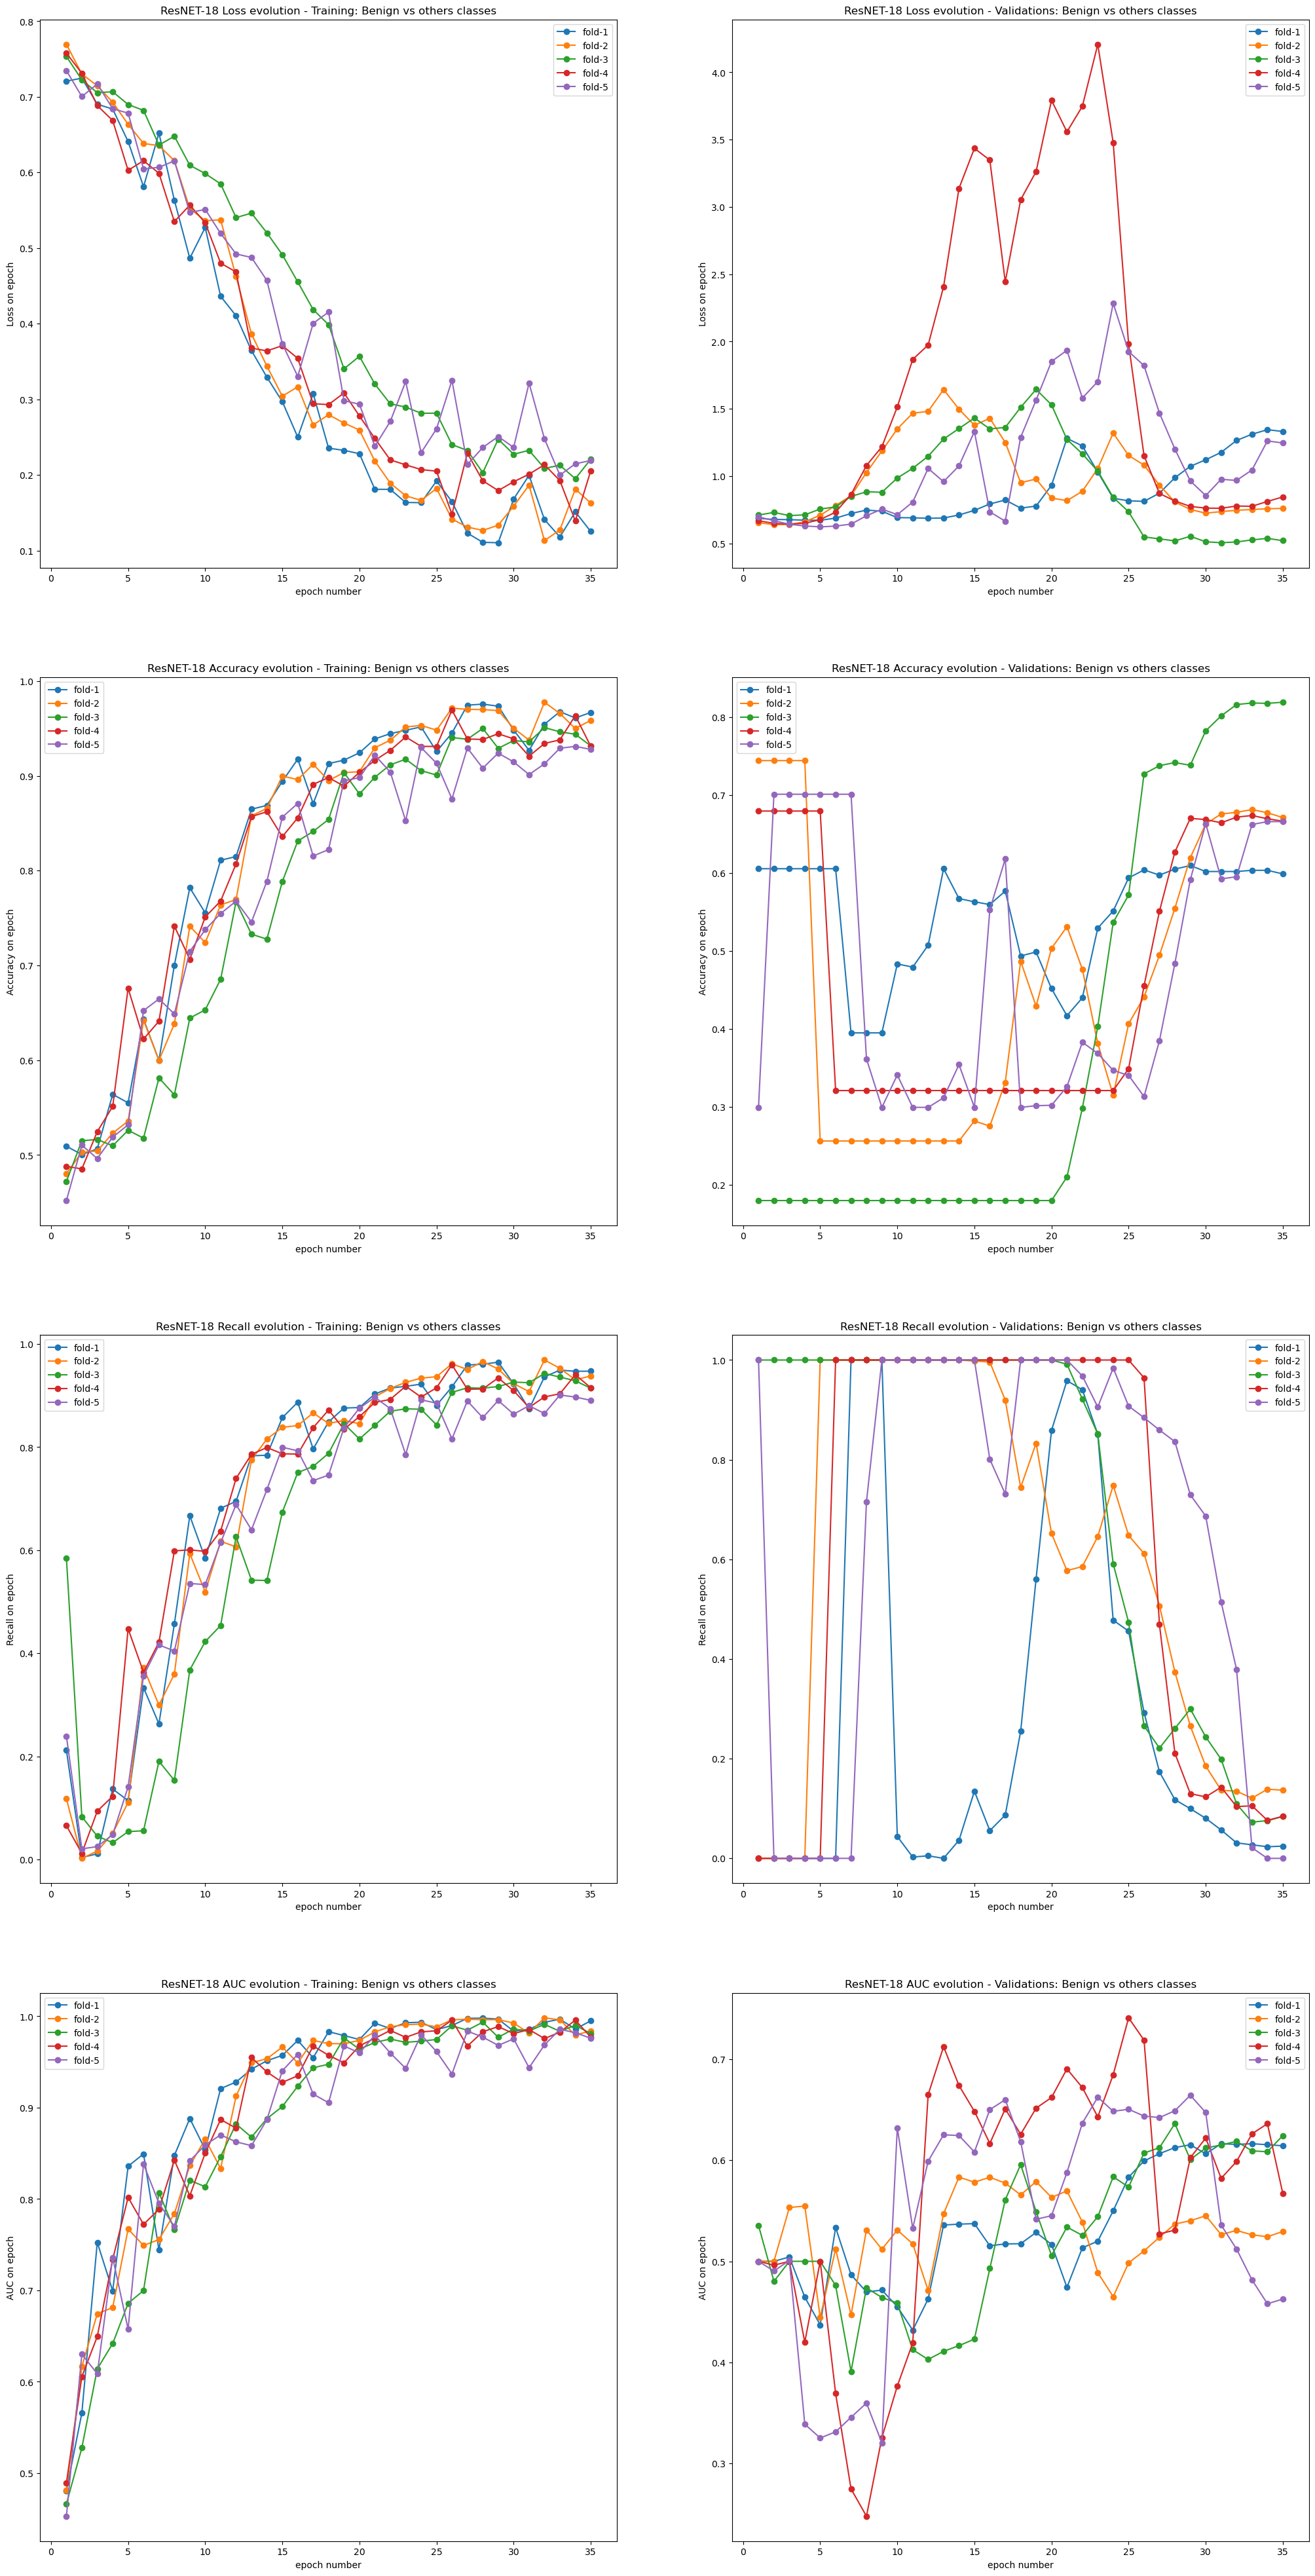

In [21]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Validations: Benign vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-18 AUC evolution - Training: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-18 AUC evolution - Validations: Benign vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [22]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9980320930480957
Best Accuracy in train: 0.9756244421005249
Best Precision in train: 0.9900497794151306
Best Recall in train: 0.9647887349128723

VALIDATION RESULTS:
Best AUC in validation: 0.6164128184318542
Best Accuracy in validation: 0.6094069480895996
Best Precision in validation: 0.5273972749710083
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.9983356595039368
Best Accuracy in train: 0.9776653051376343
Best Precision in train: 1.0
Best Recall in train: 0.9689366817474365

VALIDATION RESULTS:
Best AUC in validation: 0.5833436250686646
Best Accuracy in validation: 0.7440782785415649
Best Precision in validation: 0.2983871102333069
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9935991764068604
Best Accuracy in train: 0.9508745074272156
Best Precision in train: 0.9842932224273682
Best Recall in train: 0.942812979221344



**CANCER**

In [16]:
checkpoint_callback_auc1 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_1',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc2 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_2',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc3 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc3/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_3',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc4 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc4/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_4',
                                                             mode='max',
                                                             save_best_only=True)
checkpoint_callback_auc5 = tf.keras.callbacks.ModelCheckpoint(filepath='./models/cancer_auc5/',
                                                             save_weights_only=True,
                                                             monitor='val_AUC_5',
                                                             mode='max',
                                                             save_best_only=True)

callbacks_list = [checkpoint_callback_auc1, 
                  checkpoint_callback_auc2, 
                  checkpoint_callback_auc3, 
                  checkpoint_callback_auc4, 
                  checkpoint_callback_auc5]

def lr_scheduler(epoch, lr):
    return lr*0.9

lr_decay_function = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=0)

In [17]:
histories = []
n_splits = 5
skf = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=314, train_size=0.85)
for number_of_split, data in enumerate(skf.split(X_train, y_train)):
    print(f'SPLIT {number_of_split+1}/{n_splits}:')
    train = [path + dirs[i] for i in data[0]]
    val = [path + dirs[j] for j in data[1]]
    
    # Generators
    training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
    validation_generator = DataGenerator(objective=[0, 0, 0, 1],
                                         list_IDs=val, 
                                         labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                         dim_img=(192, 256), 
                                         batch_size=1,
                                         sub_batch_size='IGNORED', #this argument will be ignored because training is false.
                                         shuffle=True, 
                                         training=False)
    
    resnet = get_resnet18()
    
    resnet.compile(loss='binary_crossentropy', 
                     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                     metrics=[keras.metrics.AUC(name=f'AUC_{number_of_split+1}'),
                              keras.metrics.BinaryAccuracy(name='accuracy'),
                              keras.metrics.Precision(name='precision'),
                              keras.metrics.Recall(name='recall')])
                                                               

    # Train model on dataset
    histories.append(resnet.fit(training_generator,
                                   validation_data=validation_generator, 
                                   epochs=35,
                                   use_multiprocessing=True,
                                   workers=1,
                                   callbacks=[callbacks_list[number_of_split], lr_decay_function]))
    print('\n')
    collect()

SPLIT 1/5:
Epoch 1/35
29/29 [==============================] - 94s 2s/step - loss: 0.7255 - AUC_1: 0.5250 - accuracy: 0.5135 - precision: 0.5202 - recall: 0.2772 - val_loss: 0.6675 - val_AUC_1: 0.4929 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 9.0000e-05
Epoch 2/35
29/29 [==============================] - 55s 2s/step - loss: 0.7386 - AUC_1: 0.7125 - accuracy: 0.5026 - precision: 0.6250 - recall: 0.0035 - val_loss: 0.6789 - val_AUC_1: 0.4217 - val_accuracy: 0.8819 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 8.1000e-05
Epoch 3/35
29/29 [==============================] - 54s 2s/step - loss: 0.6414 - AUC_1: 0.8049 - accuracy: 0.5777 - precision: 0.8507 - recall: 0.1834 - val_loss: 0.7677 - val_AUC_1: 0.4386 - val_accuracy: 0.1181 - val_precision: 0.1181 - val_recall: 1.0000 - lr: 7.2900e-05
Epoch 4/35
29/29 [==============================] - 53s 2s/step - loss: 0.6442 - AUC_1: 0.7965 - accuracy: 0.6032 - precision: 0.7904 - recall: 0.27

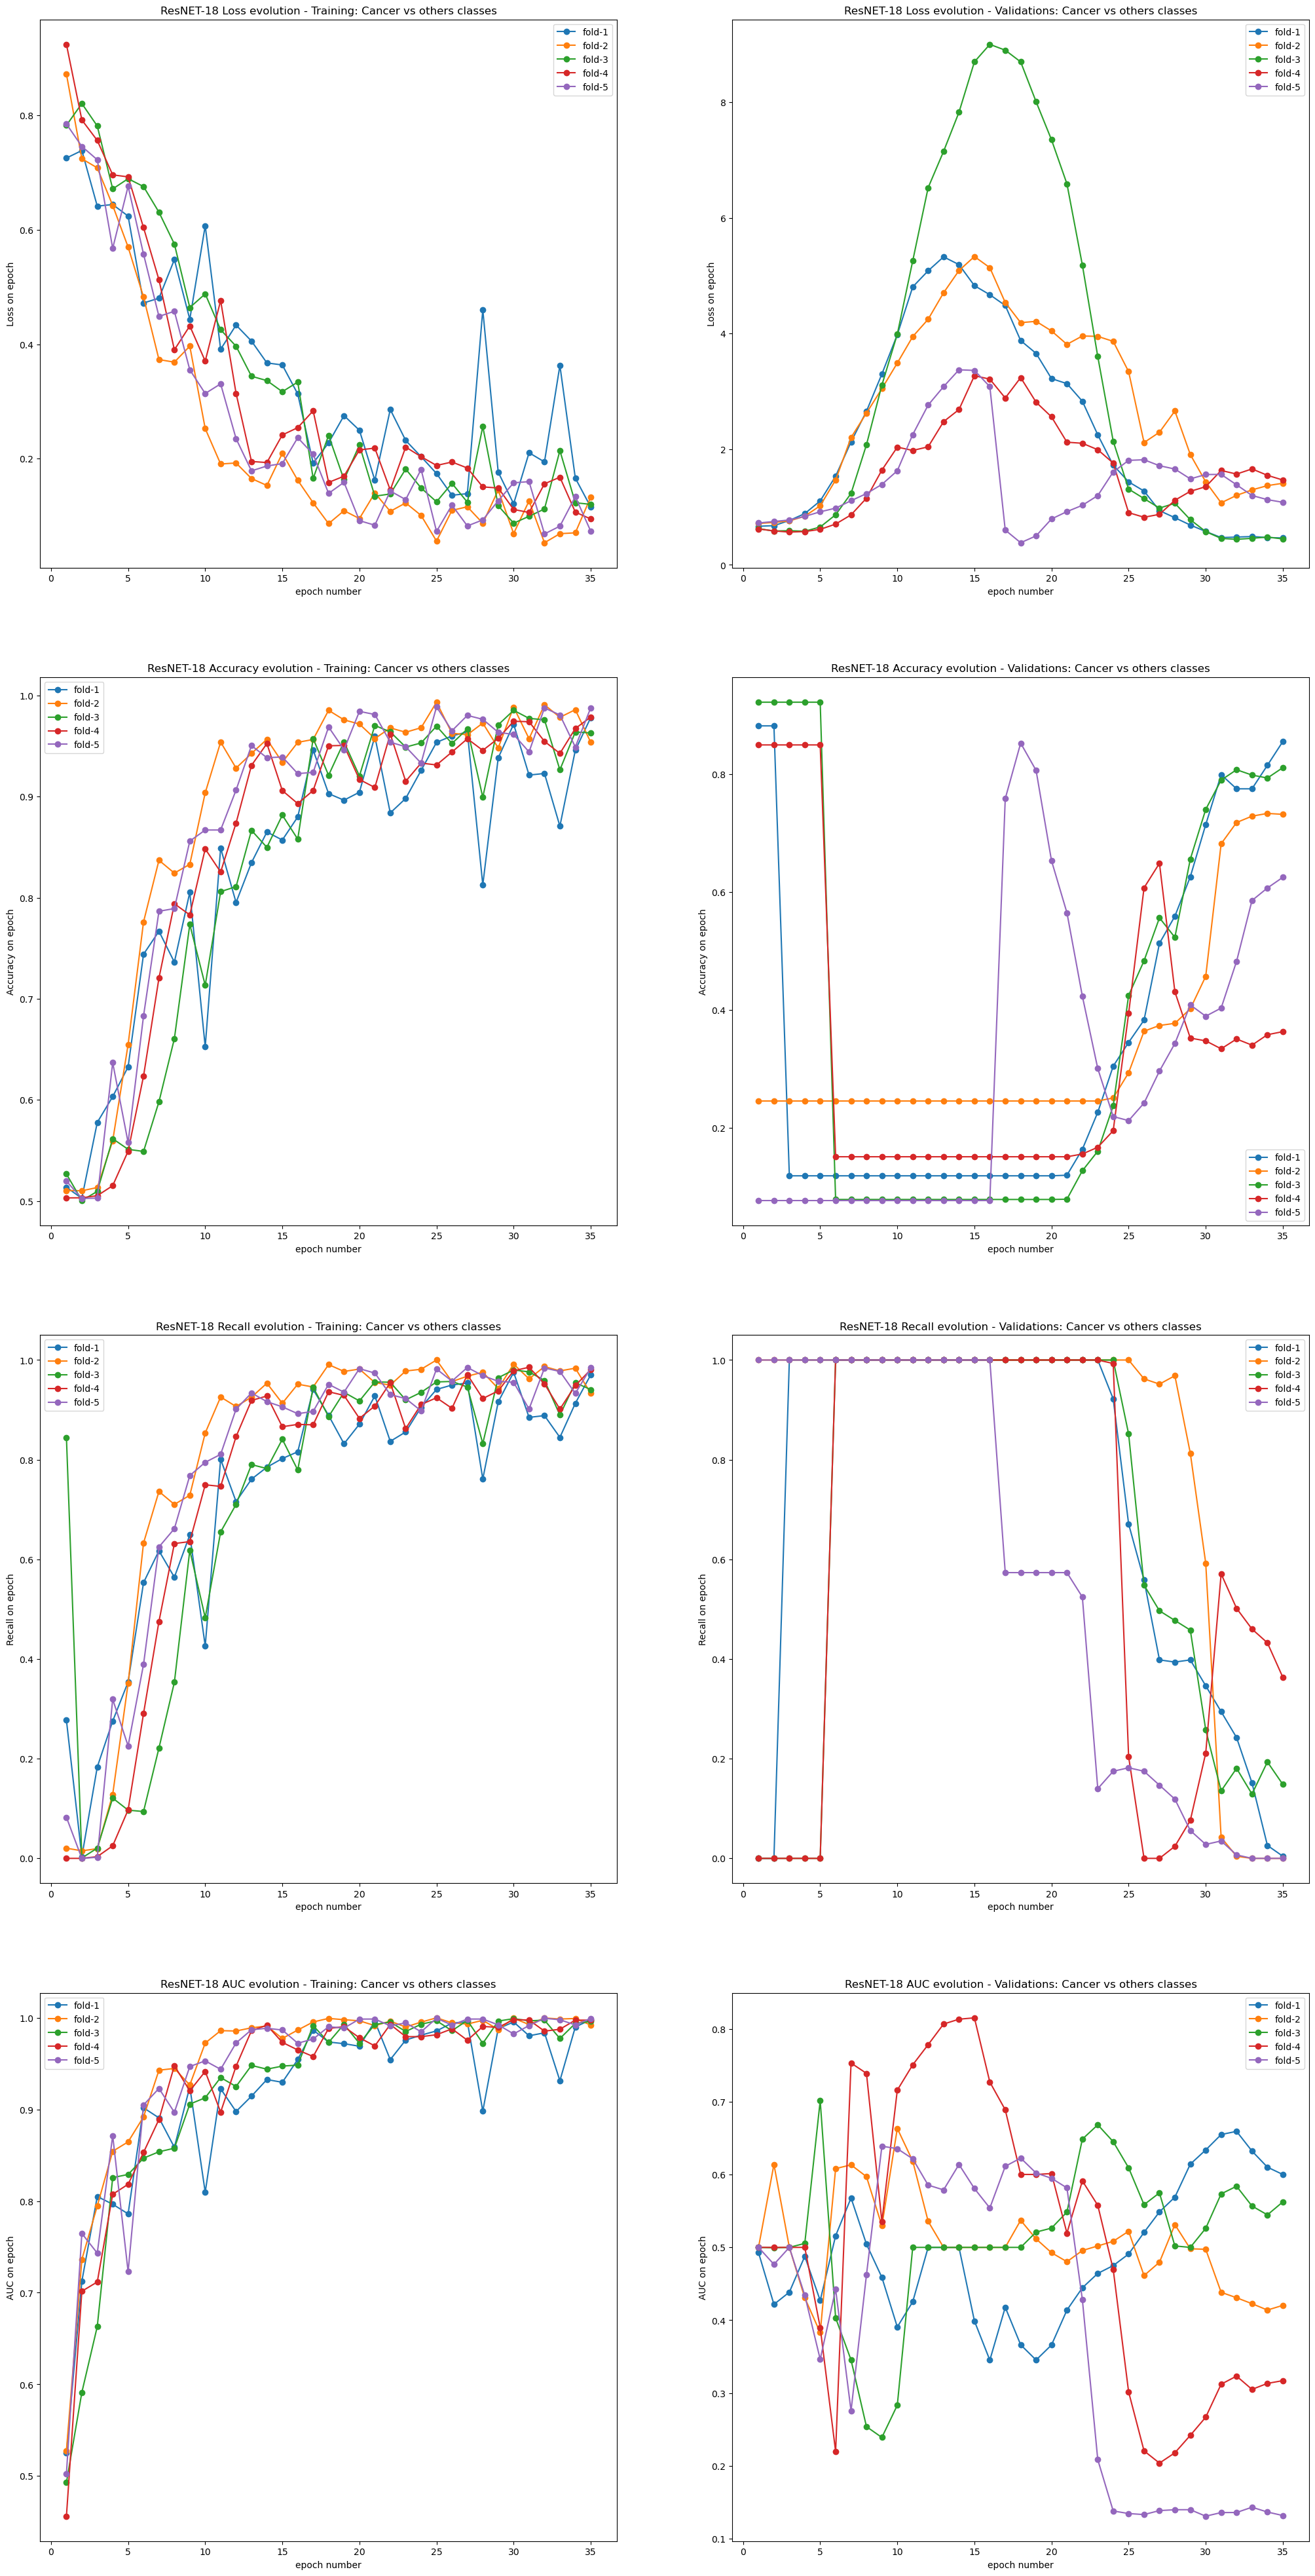

In [18]:
plt.figure(figsize=(25, 50))
plt.subplot(4, 2, 1) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

plt.subplot(4, 2, 2) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_loss'], marker='o') 
    plt.title('ResNET-18 Loss evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Loss on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 3) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 4) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_accuracy'], marker='o') 
    plt.title('ResNET-18 Accuracy evolution - Validations: Cancer vs others classes')  
    plt.xlabel('epoch number') 
    plt.ylabel('Accuracy on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 5) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 6) 
for i, h in enumerate(histories): 
    plt.plot(list(range(1, 36)), h.history['val_recall'], marker='o') 
    plt.title('ResNET-18 Recall evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('Recall on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 7) 
for i, h in enumerate(histories): 
    key_auc = f"AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc], marker='o') 
    plt.title('ResNET-18 AUC evolution - Training: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])
    
plt.subplot(4, 2, 8) 
for i, h in enumerate(histories): 
    key_auc_val = f"val_AUC_{i+1}"
    plt.plot(list(range(1, 36)), h.history[key_auc_val], marker='o') 
    plt.title('ResNET-18 AUC evolution - Validations: Cancer vs others classes') 
    plt.xlabel('epoch number') 
    plt.ylabel('AUC on epoch') 
    plt.legend(['fold-1','fold-2', 'fold-3', 'fold-4', 'fold-5'])

In [19]:
print('Best results in validations for any k-fold: ')
for i, h in enumerate(histories):
    print(f'K-FOLD {i+1}:')
    print("TRAINING RESULTS:")
    k = np.max(h.history[f'AUC_{i+1}'])
    print(f'Best AUC in train: {k}')
    k = np.max(h.history[f'accuracy'])
    print(f'Best Accuracy in train: {k}')
    k = np.max(h.history[f'precision'])
    print(f'Best Precision in train: {k}')
    k = np.max(h.history[f'recall'])
    print(f'Best Recall in train: {k}')
    
    print("\nVALIDATION RESULTS:")
    k = np.max(h.history[f'val_AUC_{i+1}'])
    print(f'Best AUC in validation: {k}')
    k = np.max(h.history[f'val_accuracy'])
    print(f'Best Accuracy in validation: {k}')
    k = np.max(h.history[f'val_precision'])
    print(f'Best Precision in validation: {k}')
    k = np.max(h.history[f'val_recall'])
    print(f'Best Recall in validation: {k}')
    print()
    print(f'{50*"="}')
    print()

results = np.empty((4, 5))
for i, h in enumerate(histories):
    results[0][i] = np.max(h.history[f'val_AUC_{i+1}'])
    results[1][i] = np.max(h.history['val_accuracy'])
    results[2][i] = np.max(h.history['val_precision'])
    results[3][i] = np.max(h.history['val_recall'])

print(f"Average best AUC: {np.mean(results[0])}")
print(f"standard deviation AUC: {np.std(results[0])}\n")
print(f"Average best Accuracy: {np.mean(results[1])}")
print(f"Standard Deviation Accuracy: {np.std(results[1])}\n")
print(f"Average best Precision: {np.mean(results[2])}")
print(f"Standard Deviation Precision: {np.std(results[2])}\n")
print(f"Average best Recall: {np.mean(results[3])}")
print(f"Standard Deviation Recall: {np.std(results[3])}\n")

Best results in validations for any k-fold: 
K-FOLD 1:
TRAINING RESULTS:
Best AUC in train: 0.9978200793266296
Best Accuracy in train: 0.9781613349914551
Best Precision in train: 0.9900632500648499
Best Recall in train: 0.9753276705741882

VALIDATION RESULTS:
Best AUC in validation: 0.6592684984207153
Best Accuracy in validation: 0.8819018602371216
Best Precision in validation: 0.2281879186630249
Best Recall in validation: 1.0


K-FOLD 2:
TRAINING RESULTS:
Best AUC in train: 0.999864935874939
Best Accuracy in train: 0.9933540225028992
Best Precision in train: 0.9946808218955994
Best Recall in train: 1.0

VALIDATION RESULTS:
Best AUC in validation: 0.6632909178733826
Best Accuracy in validation: 0.733264684677124
Best Precision in validation: 0.2783816456794739
Best Recall in validation: 1.0


K-FOLD 3:
TRAINING RESULTS:
Best AUC in train: 0.9990008473396301
Best Accuracy in train: 0.9853349328041077
Best Precision in train: 0.9924242496490479
Best Recall in train: 0.980063796043396

VA

**TESTS**

NORMAL VS OTHERS

In [10]:
training_generator = DataGenerator(objective=[1, 0, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_resnet18()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/normal_auc4/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 108s 2s/step - loss: 0.4527 - AUC: 0.8705 - accuracy: 0.7934 - precision: 0.8104 - recall: 0.7659
Epoch 2/10
35/35 [==============================] - 38s 1s/step - loss: 0.4126 - AUC: 0.8944 - accuracy: 0.8129 - precision: 0.8366 - recall: 0.7775
Epoch 3/10
35/35 [==============================] - 43s 1s/step - loss: 0.3793 - AUC: 0.9159 - accuracy: 0.8374 - precision: 0.8567 - recall: 0.8102
Epoch 4/10
35/35 [==============================] - 36s 1s/step - loss: 0.3368 - AUC: 0.9371 - accuracy: 0.8681 - precision: 0.9051 - recall: 0.8222
Epoch 5/10
35/35 [==============================] - 37s 1s/step - loss: 0.3104 - AUC: 0.9493 - accuracy: 0.8829 - precision: 0.9110 - recall: 0.8484
Epoch 6/10
35/35 [==============================] - 39s 1s/step - loss: 0.2805 - AUC: 0.9585 - accuracy: 0.9015 - precision: 0.9151 - recall: 0.8850
Epoch 7/10
35/35 [==============================] - 41s 1s/step - loss: 0.2961 - AUC: 0.9504 - accuracy: 

In [11]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [12]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 0:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[20  8]
 [ 9  8]]
0.6222222222222222


ACTIONABLE VS OTHERS

In [20]:
training_generator = DataGenerator(objective=[0, 1, 0, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_resnet18()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/benign_auc4/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 62s 1s/step - loss: 1.2318 - AUC: 0.4523 - accuracy: 0.4290 - precision: 0.3977 - recall: 0.2781
Epoch 2/10
35/35 [==============================] - 38s 1s/step - loss: 1.0299 - AUC: 0.4801 - accuracy: 0.4639 - precision: 0.4434 - recall: 0.2917
Epoch 3/10
35/35 [==============================] - 36s 1s/step - loss: 0.9277 - AUC: 0.5431 - accuracy: 0.5115 - precision: 0.5154 - recall: 0.3665
Epoch 4/10
35/35 [==============================] - 35s 1s/step - loss: 0.8482 - AUC: 0.5745 - accuracy: 0.5374 - precision: 0.5519 - recall: 0.3901
Epoch 5/10
35/35 [==============================] - 35s 1s/step - loss: 0.7722 - AUC: 0.6187 - accuracy: 0.5735 - precision: 0.6039 - recall: 0.4232
Epoch 6/10
35/35 [==============================] - 36s 1s/step - loss: 0.8891 - AUC: 0.5111 - accuracy: 0.5038 - precision: 0.5038 - recall: 0.3570
Epoch 7/10
35/35 [==============================] - 37s 1s/step - loss: 0.7390 - AUC: 0.6321 - accuracy: 0

In [21]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [22]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 1:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[33 12]
 [ 0  0]]
0.7333333333333333


BENIGN VS OTHERS

In [14]:
training_generator = DataGenerator(objective=[0, 0, 1, 0],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_resnet18()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/actionable_auc4/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 57s 1s/step - loss: 0.7345 - AUC: 0.4633 - accuracy: 0.4408 - precision: 0.3707 - recall: 0.1712
Epoch 2/10
35/35 [==============================] - 35s 1s/step - loss: 0.6875 - AUC: 0.6351 - accuracy: 0.5312 - precision: 0.5899 - recall: 0.1965
Epoch 3/10
35/35 [==============================] - 37s 1s/step - loss: 0.6624 - AUC: 0.6838 - accuracy: 0.5984 - precision: 0.6849 - recall: 0.3627
Epoch 4/10
35/35 [==============================] - 34s 980ms/step - loss: 0.6215 - AUC: 0.7386 - accuracy: 0.6193 - precision: 0.7086 - recall: 0.4038
Epoch 5/10
35/35 [==============================] - 34s 968ms/step - loss: 0.6330 - AUC: 0.7329 - accuracy: 0.6437 - precision: 0.7252 - recall: 0.4597
Epoch 6/10
35/35 [==============================] - 34s 971ms/step - loss: 0.6093 - AUC: 0.7650 - accuracy: 0.6646 - precision: 0.7528 - recall: 0.4881
Epoch 7/10
35/35 [==============================] - 35s 986ms/step - loss: 0.5082 - AUC: 0.8638 -

In [15]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 2:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[ 3  1]
 [31 10]]
0.28888888888888886


CANCER VS OTHERS

In [17]:
training_generator = DataGenerator(objective=[0, 0, 0, 1],
                                       list_IDs=X_train, 
                                       labels_dir='/kaggle/input/labelsssss/labels.csv', 
                                       dim_img=(192, 256), 
                                       batch_size=5,
                                       sub_batch_size=400,
                                       shuffle=True, 
                                       training=True)
    
resnet = get_resnet18()    
    
resnet.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(8e-7),
                  metrics=[keras.metrics.AUC(name='AUC'),
                           keras.metrics.BinaryAccuracy(name='accuracy'),
                           keras.metrics.Precision(name='precision'),
                           keras.metrics.Recall(name='recall')])


# Train model on dataset
resnet.load_weights('/kaggle/working/models/cancer_auc4/') #start with best AUC in validations
history = resnet.fit(training_generator, epochs=10)

Epoch 1/10
35/35 [==============================] - 54s 971ms/step - loss: 0.3493 - AUC: 0.9399 - accuracy: 0.8439 - precision: 0.9027 - recall: 0.7692
Epoch 2/10
35/35 [==============================] - 35s 997ms/step - loss: 0.5947 - AUC: 0.8342 - accuracy: 0.7421 - precision: 0.7842 - recall: 0.6627
Epoch 3/10
35/35 [==============================] - 36s 1s/step - loss: 0.3161 - AUC: 0.9520 - accuracy: 0.8716 - precision: 0.9263 - recall: 0.8057
Epoch 4/10
35/35 [==============================] - 33s 939ms/step - loss: 0.2468 - AUC: 0.9720 - accuracy: 0.9057 - precision: 0.9356 - recall: 0.8704
Epoch 5/10
35/35 [==============================] - 33s 947ms/step - loss: 0.1687 - AUC: 0.9918 - accuracy: 0.9515 - precision: 0.9677 - recall: 0.9337
Epoch 6/10
35/35 [==============================] - 34s 966ms/step - loss: 0.1594 - AUC: 0.9896 - accuracy: 0.9388 - precision: 0.9593 - recall: 0.9156
Epoch 7/10
35/35 [==============================] - 33s 948ms/step - loss: 0.2875 - AUC: 0.

In [18]:
res = []
for x in X_train:
    x = np.load(x)
    x = np.array(separate_slices(x))
    pred = resnet.predict(np.array(x), verbose=0)
    if (pred.mean() > 0.5):
        res.append(1)
    else:
        res.append(0)
print(res)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
matrix_confusion = np.array([[0, 0], [0, 0]])

for y_pred, y_true in zip(res, y_test):
    if y_true != 3:
        y_true = 0
    else:
        y_true = 1
    
    matrix_confusion[y_pred][y_true] += 1
print(matrix_confusion)
print((matrix_confusion[0][0] + matrix_confusion[1][1])/matrix_confusion.sum())

[[37  5]
 [ 2  1]]
0.8444444444444444
